# Set Environment

In [ ]:
# !pip install pytorch_tabnet    # tabnet 모델 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# main_dir = '/content/drive/MyDrive/SKKU_study/01_Final_assignment'
# data_dir = os.path.join(main_dir, 'data')
# processed_data_dir = os.path.join(data_dir, 'processed')
#
# os.makedirs(data_dir, exist_ok=True)
# os.makedirs(processed_data_dir, exist_ok=True)

# Load Data

In [5]:
dfs = pd.read_csv('./processed.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape, test.shape

((75000, 23), (25000, 23))

In [6]:
le = LabelEncoder()
dfs['Month'] = le.fit_transform(dfs['Month'])
train['Month'] = le.transform(train['Month'])
test['Month'] = le.transform(test['Month'])

# Model

In [7]:
class F1_Score(Metric):
    def __init__(self):
        self._name = 'f1'
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1, average='micro')
        return score

In [9]:
target = 'Credit_Score'
cat_col = ['Customer_ID', 'Month', 'Credit_Mix', 'Credit_History_Age', 
           'Payment_of_Min_Amount', 'Payment_Behaviour']
cat_dims = {}
for col in cat_col:
    cat_dims[col] = len(list(dfs[col].unique()))
    print(col, ': ', cat_dims[col])
cat_col_idx = [list(dfs.columns).index(col) for col in cat_col]
cat_col_dims = [cat_dims[col] for col in cat_col]
all_col_list = [col for col in dfs.columns if col !=target]

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Payment_of_Min_Amount :  3
Payment_Behaviour :  6


In [10]:
x_train = train.loc[:, all_col_list].values
y_train = train.loc[:, target].values
x_test = test.loc[:, all_col_list].values
y_test = test.loc[:, target].values

In [11]:
# pretrain model
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5*1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train=x_train,
    max_epochs=90,
    drop_last=False,
    pretraining_ratio=0.6, #0.5
)

reconstructed_X, embedded_X = unsupervised_model.predict(x_train)
assert(reconstructed_X.shape == embedded_X.shape)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 4.28025 |  0:00:17s
epoch 1  | loss: 2.20452 |  0:00:40s
epoch 2  | loss: 1.704   |  0:00:57s
epoch 3  | loss: 1.3925  |  0:01:15s
epoch 4  | loss: 1.22133 |  0:01:31s
epoch 5  | loss: 1.08775 |  0:01:47s
epoch 6  | loss: 1.05976 |  0:02:04s
epoch 7  | loss: 1.04708 |  0:02:22s
epoch 8  | loss: 1.03525 |  0:02:38s
epoch 9  | loss: 1.01098 |  0:02:55s
epoch 10 | loss: 0.99055 |  0:03:13s
epoch 11 | loss: 0.97678 |  0:03:30s
epoch 12 | loss: 0.96681 |  0:03:47s
epoch 13 | loss: 0.95964 |  0:04:02s
epoch 14 | loss: 0.95438 |  0:04:17s
epoch 15 | loss: 0.95037 |  0:04:33s
epoch 16 | loss: 0.94805 |  0:04:50s
epoch 17 | loss: 0.94625 |  0:05:05s
epoch 18 | loss: 0.93837 |  0:05:20s
epoch 19 | loss: 0.9336  |  0:05:40s
epoch 20 | loss: 0.92915 |  0:05:56s
epoch 21 | loss: 0.92649 |  0:06:15s
epoch 22 | loss: 0.92034 |  0:06:30s
epoch 23 | loss: 0.91689 |  0:06:45s
epoch 24 | loss: 0.91

In [14]:
from sklearn.utils.class_weight import compute_class_weight

In [15]:
weights = compute_class_weight(class_weight = "balanced" ,
                               classes=np.unique(y_train),
                               y = y_train)

weights

array([1.14773666, 0.62167404, 1.92248539])

In [16]:
model = TabNetClassifier(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='sparsemax',
    gamma=1.3,
    )

Device used : cpu


In [18]:
model.fit(
    X_train=x_train, 
    y_train=y_train,
    eval_set=[(x_train, y_train)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=1,  # 0: no, 1: balanced, dict: customized
    batch_size=512, 
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 8.7711  | train_balanced_accuracy: 0.44558 | train_accuracy: 0.57796 |  0:00:16s
epoch 1  | loss: 1.01365 | train_balanced_accuracy: 0.74048 | train_accuracy: 0.68984 |  0:00:32s
epoch 2  | loss: 0.74499 | train_balanced_accuracy: 0.7387  | train_accuracy: 0.697   |  0:00:50s
epoch 3  | loss: 0.69845 | train_balanced_accuracy: 0.74717 | train_accuracy: 0.69551 |  0:01:07s
epoch 4  | loss: 0.66422 | train_balanced_accuracy: 0.75758 | train_accuracy: 0.71317 |  0:01:24s
epoch 5  | loss: 0.60537 | train_balanced_accuracy: 0.77796 | train_accuracy: 0.73088 |  0:01:40s
epoch 6  | loss: 0.55496 | train_balanced_accuracy: 0.8043  | train_accuracy: 0.76481 |  0:01:56s
epoch 7  | loss: 0.50245 | train_balanced_accuracy: 0.82772 | train_accuracy: 0.79704 |  0:02:13s
epoch 8  | loss: 0.45662 | train_balanced_accuracy: 0.84491 | train_accuracy: 0.81801 |  0:02:50s
epoch 9  | loss: 0.42325 | train_balanced_accuracy: 0.86132 | train_accu

# Result

In [19]:
from sklearn.metrics import classification_report

In [20]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.708
Month :  0.03
Age :  0.001
Monthly_Inhand_Salary :  0.017
Num_Bank_Accounts :  0.004
Num_Credit_Card :  0.007
Interest_Rate :  0.024
Num_of_Loan :  0.0
Delay_from_due_date :  0.002
Num_of_Delayed_Payment :  0.009
Changed_Credit_Limit :  0.001
Num_Credit_Inquiries :  0.015
Credit_Mix :  0.078
Outstanding_Debt :  0.034
Credit_Utilization_Ratio :  0.002
Credit_History_Age :  0.019
Payment_of_Min_Amount :  0.011
Total_EMI_per_month :  0.006
Amount_invested_monthly :  0.006
Payment_Behaviour :  0.0
Monthly_Balance :  0.028


In [23]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.85      0.99      0.92     21782
           1       0.99      0.86      0.92     40214
           2       0.86      0.99      0.92     13004

    accuracy                           0.92     75000
   macro avg       0.90      0.95      0.92     75000
weighted avg       0.93      0.92      0.92     75000



In [26]:
# f1_score(y_train, (model.predict(x_train)))

In [27]:
predicted = model.predict(x_test)

In [28]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.7489961247812217
0.7496


In [29]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.72      0.84      0.78      7216
           1       0.79      0.71      0.75     12960
           2       0.71      0.73      0.72      4824

    accuracy                           0.75     25000
   macro avg       0.74      0.76      0.75     25000
weighted avg       0.75      0.75      0.75     25000



In [31]:
print(confusion_matrix(y_test, predicted))

[[6055 1156    5]
 [2333 9156 1471]
 [  12 1283 3529]]


class weight 부여 후 0과 2클래스에 대해 더 많이 맞췄음.

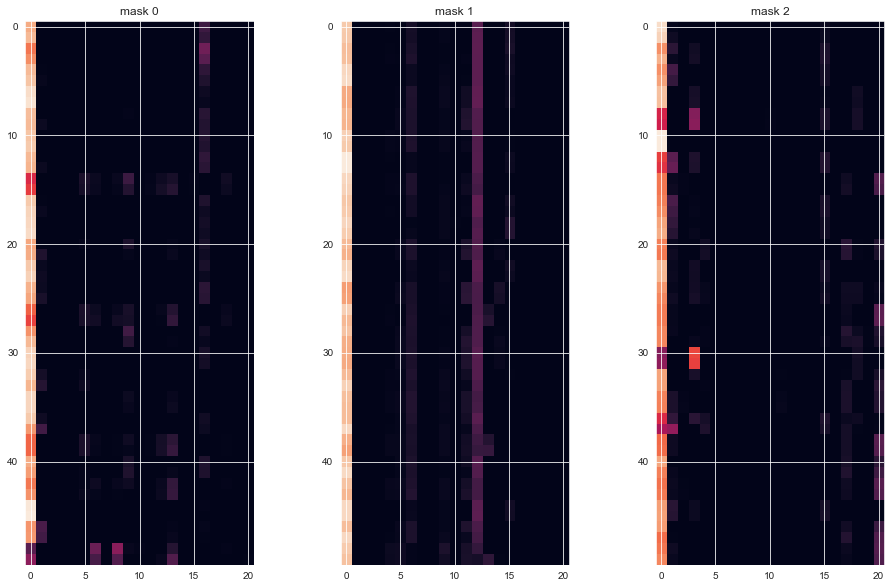

In [32]:
explain_matrix, masks = model.explain(x_test)

fig, axs = plt.subplots(1, 3, figsize=(16,10))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [33]:
train.columns

Index(['Customer_ID', 'Month', 'Age', 'Occupation', 'Monthly_Inhand_Salary',
       'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')